<img src="images/keepcoding.png" width=200 align="left">

# Módulo de Matemáticas 101: reto del fin de semana

El reto de esta semana es implementar el algoritmo de Singular Value Decomposition para comprimir una imagen. Podéis guiaros por lo visto en las clases y os recomiendo también esta web:

https://timbaumann.info/svd-image-compression-demo/

## SVD para comprimir una imagen

El algoritmo de Singular Value Decomposition, del que ya hemos hablado en el módulo, nos puede servir para comprimir una imagen. Vamos a implementar varias funciones para esto. Como repaso, el algoritmo nos devuelve la descomposición de una matriz en tres matrices, una de ellas con los elementos principales y las otras dos con los vectores principales.

Usaremos:

- Una imagen de `scipy.datasets`
- La implementación del algoritmo en `scipy.linalg`: https://docs.scipy.org/doc/scipy-1.14.0/reference/generated/scipy.linalg.svd.html
- La librería `matplotlib`para las gráficas
- El error SSE (sum of squared estimate of errors)


Definición:

$$SSE =  \sum_{i=1}^{n}  (x_{i} -  \widehat{x}_i ) ^2 $$

Donde:

- $x_i$ son los valores de la matriz original X
- $\widehat{x}_i$ son los valores de la matriz reconstruida $\widehat{X}$

Lo primero, vemos la imagen que vamos a comprimir:

In [288]:
pip install pooch


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


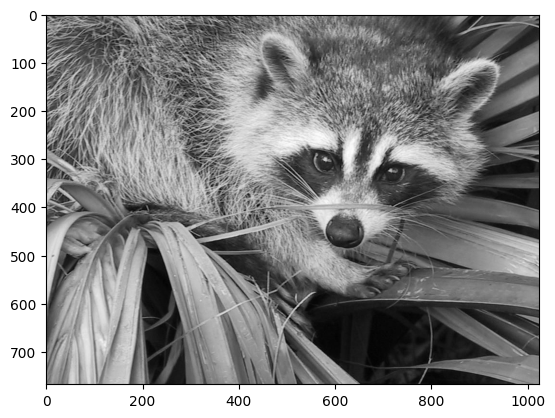

In [289]:
import matplotlib.pyplot as plt
from scipy import misc, datasets
%matplotlib inline

# Load image
A = datasets.face(gray=True)

plt.imshow(A, cmap=plt.cm.gray)

In [290]:
A

array([[114, 130, 145, ..., 119, 129, 137],
       [ 83, 104, 123, ..., 118, 134, 146],
       [ 68,  88, 109, ..., 119, 134, 145],
       ...,
       [ 98, 103, 116, ..., 144, 143, 143],
       [ 94, 104, 120, ..., 143, 142, 142],
       [ 94, 106, 119, ..., 142, 141, 140]], dtype=uint8)

In [291]:
type(A)

numpy.ndarray

Las siguientes funciones te ayudarán a llegar a la solución final:

### 1. Implementa la función para el SEE (en clase)
La función debe tener como entrada las dos matrices y como salida un número que será el error cometido.

In [292]:
import numpy as np

def sse_score(X, X_hat):
    return np.sum((X - X_hat)**2) 

X = np.array([[1, 2], [3, 4]])
X_hat = np.array([[1.01, 1.75], [2.81, 3.99]])
sse = sse_score(X, X_hat)  
print(sse)

0.09879999999999997


### 2. Implementa una función para ejecutar SVD
La función debe tener como entrada una matriz y como salida las tres matrices de la descomposición.

In [293]:
import numpy as np
from scipy import linalg

def svm(X):
    # Definimos la función donde usamos linalg.svd de scipy
    U, S, Vt = linalg.svd(X, full_matrices = False)
    return U, S, Vt # S es una matriz diagonal

X = np.array([[1, 2], [3, 4]])
U, S, Vt = svm(X)  
print(U)
print(S)
print(Vt)

[[-0.40455358 -0.9145143 ]
 [-0.9145143   0.40455358]]
[5.4649857  0.36596619]
[[-0.57604844 -0.81741556]
 [ 0.81741556 -0.57604844]]


### 3. Implementa una función para reconstruir la imagen

Esta función deberá reconstruir la imagen a partir de un set de matrizes (U, S, Vt) dado.

In [300]:
U,S,Vt = svm(A)
def reconstruction(U, S, Vt, n_val):
    #Obtenemos la diagonal de S
    S = np.diag(S) 
    #Calculamos la matriz S reducida dejando filas hasta n_valores y columna hasta n_valores
    S_red =S[:n_val , :n_val] 
    print('Dimemsión de S_red: ', S_red.shape)
    #Calculamos U reducida dejando todas las filas y tomando las columnas hasta n_valores
    U_red=U[:,:n_val] 
    print('Dimemsión de U_red: ', U_red.shape)
    #Calculamos Vt reducida tomando las filas hasta n_valores y dejando todas las columnas
    Vt_red=Vt[:n_val,:] 
    print('Dimemsión de Vt_red: ', Vt_red.shape)
    # Calculamos el resultado haciendo la multiplicación entre U_red, S_red y Vt_red
    result = np.dot(U_red,np.dot(S_red, Vt_red)) 
    return result


A_hat = reconstruction(U, S, Vt,2)
A_hat

Dimemsión de S_red:  (2, 2)
Dimemsión de U_red:  (768, 2)
Dimemsión de Vt_red:  (2, 1024)


array([[111.43559 , 111.772644, 112.32014 , ...,  76.94458 ,  77.17704 ,
         77.29614 ],
       [112.25827 , 112.560844, 113.070885, ...,  77.947914,  78.18413 ,
         78.30357 ],
       [117.17229 , 117.32553 , 117.67536 , ...,  83.27465 ,  83.5302  ,
         83.65254 ],
       ...,
       [124.46868 , 123.33348 , 122.247894, ..., 103.74563 , 104.08886 ,
        104.20022 ],
       [123.318565, 122.20789 , 121.1481  , ..., 102.62163 , 102.96092 ,
        103.07145 ],
       [122.65643 , 121.570335, 120.53713 , ..., 101.851425, 102.18787 ,
        102.29807 ]], dtype=float32)

En este punto, ya puedes ver cuál es el error cometido si se reconstruye la matriz inicial directamente después de aplicar SVD.

In [295]:
sse = sse_score(A, A_hat)
print(f"El error de reconstrucción es: {sse}")

El error de reconstrucción es: 1364834432.0


### 4. Implementa la compresión

Esta es la parte más complicada. A la función le tendremos que pasar la imagen, en forma matricial, y el número de componentes que queremos usar para la compresión.

La función aplicará SVD y reconstruirá la matriz usando solo los n_comp primeros valores propios de la descomposición. 

In [296]:
### TODO: Función que recibe una imagen A y devuelve la imagen comprimida
### Tiene como entrada A y el número de componentes para realizar la reducción de dimensionalidad
### Devuelve la imagen comprimidad y el error de reconstrucción

def image_compression(A, n_comp):
    # TODO 1: Aplicar SVD (usando la función que hemos creado)
    
    U,S,Vt = svm(A)
    
    # TODO 2: Reconstruir usando solo el número de componentes n_comp (usando la función que hemos creado)
    
    A_hat = reconstruction(U, S, Vt,n_comp)
    
    # TODO 3: Calcular el error
    
    sse = sse_score(A, A_hat)

    return A_hat, sse # A_hat es la matriz comprimida y sse es su error respecto de A

racoon = misc.face(gray=True)
racoon_hat, sse = image_compression(racoon, 100)

/var/folders/05/sv8_llj514lcq63wxpr_x0gr0000gn/T/ipykernel_3433/1150999804.py:20: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  racoon = misc.face(gray=True)


Dimemsión de S_red:  (100, 100)
Dimemsión de U_red:  (768, 100)
Dimemsión de Vt_red:  (100, 1024)


### 5. Gráficas del resultado

Por último, se pide que pruebes para varios valores del número de componentes y grafiques la imagen original junto con varias compresiones. Puedes usar un grid 2x2 de `matplotlib`.

/var/folders/05/sv8_llj514lcq63wxpr_x0gr0000gn/T/ipykernel_3433/899282457.py:11: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  racoon = misc.face(gray=True)


Dimemsión de S_red:  (100, 100)
Dimemsión de U_red:  (768, 100)
Dimemsión de Vt_red:  (100, 1024)


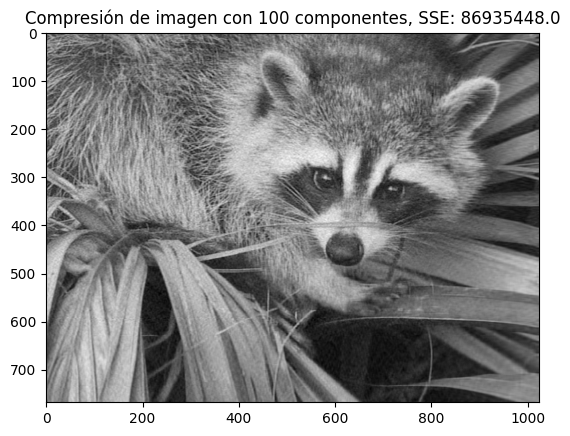

In [299]:
import matplotlib.pyplot as plt
# TODO Dibuja las graficas

# 1 Crear gráfica con plt.figure()

plt.figure()

# 2 Elegir un n_comp y aplicar la función image_compression()

n_components = 100
racoon = misc.face(gray=True)
racoon_hat, sse = image_compression(racoon, n_components)

# 3 Usar plt.imshow(A_hat, cmap=plt.cm.gray), donde A_hat va a ser la matriz comprimida resultante del paso anterior

plt.imshow(racoon_hat, cmap=plt.cm.gray)

# 4 Añadir un título a la gráfica

plt.title(f"Compresión de imagen con {n_components} componentes, SSE: {sse}")

plt.show()
# Repetir para distintas compresiones (distinto n_comp)